In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the data
events = pd.read_csv('events.csv')
app_events = pd.read_csv('app_events.csv')
app_labels = pd.read_csv('app_labels.csv')
label_categories = pd.read_csv('label_categories.csv')
phone_brand_device_model = pd.read_csv('phone_brand_device_model.csv')
training_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')

In [5]:
# Merge datasets
df = training_data.merge(phone_brand_device_model, on='device_id', how='left')
df = df.merge(events, on='device_id', how='left')
df = df.merge(app_events, on='event_id', how='left')
df = df.merge(app_labels, on='app_id', how='left')
df = df.merge(label_categories, on='label_id', how='left')

In [6]:
df.tail()

,device_id,group,phone_brand,device_model,event_id,timestamp,longitude,latitude,app_id,is_installed,is_active,label_id,category
86055651,7743219293296205681,M22-,小米,小米note,2868352.0,2016-05-07 00:40:09,104.19,30.55,3.717049e+18,1.0,0.0,183.0,map
86055652,7743219293296205681,M22-,小米,小米note,3011987.0,2016-05-01 04:21:44,104.19,30.55,NaN,NaN,NaN,NaN,NaN
86055653,-4002329493657404546,M39+,HTC,802d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86055654,-7672453909718087634,F29-32,OPPO,N1 Mini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86055655,-8642757463630124051,F43+,三星,S7568I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(86055656, 13)

In [11]:
# Aggregate app and brand/model information per device
df['apps'] = df.groupby('device_id')['category'].transform(lambda x: ' '.join(x.dropna().unique()))
df['phone_brand'] = df.groupby('device_id')['phone_brand'].transform('first')
df['device_model'] = df.groupby('device_id')['device_model'].transform('first')

In [12]:
df.tail()

,device_id,group,phone_brand,device_model,event_id,timestamp,longitude,latitude,app_id,is_installed,is_active,label_id,category,apps
86055651,7743219293296205681,M22-,小米,小米note,2868352.0,2016-05-07 00:40:09,104.19,30.55,3.717049e+18,1.0,0.0,183.0,map,Internet Banking Relatives 1 Personal Effectiv...
86055652,7743219293296205681,M22-,小米,小米note,3011987.0,2016-05-01 04:21:44,104.19,30.55,NaN,NaN,NaN,NaN,NaN,Internet Banking Relatives 1 Personal Effectiv...
86055653,-4002329493657404546,M39+,HTC,802d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
86055654,-7672453909718087634,F29-32,OPPO,N1 Mini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
86055655,-8642757463630124051,F43+,三星,S7568I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [13]:
df.shape

(86055656, 14)

In [17]:
# Drop duplicate device rows
df = df.drop_duplicates(subset='device_id')

In [19]:
df.shape

(59716, 14)

In [21]:
# Extract features and target
df['group'] = df['group'].astype(str)
X = df[['apps', 'phone_brand', 'device_model']]
y = df['group']

In [54]:
X

,apps,phone_brand,device_model
0,,vivo,X3L
1,,vivo,X710L
2,,三星,Galaxy S3 Neo+
3,,联想,A788t
4,,小米,红米note
...,...,...,...
86054990,,华为,荣耀3C
86054991,Internet Banking Relatives 1 Personal Effectiv...,小米,小米note
86055653,,HTC,802d
86055654,,OPPO,N1 Mini


In [55]:
len(y), X.shape

(59716, (59716, 3))

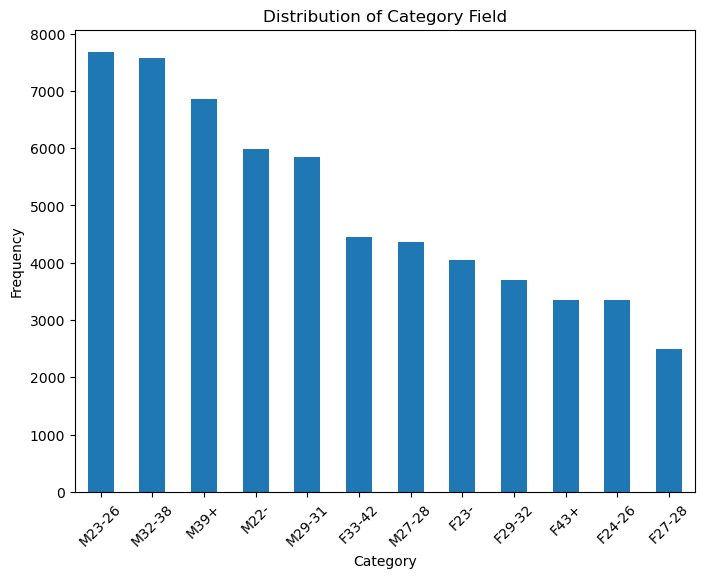

In [56]:
# 分析分布
distribution = y.value_counts()

# 绘制直条图
plt.figure(figsize=(8, 6))
distribution.plot(kind='bar')
plt.title('Distribution of Category Field')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [57]:
# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

In [88]:
# Preprocess data using Tfidf for app categories and OneHot for phone brand/model
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=500), 'apps'),
        ('brand', OneHotEncoder(handle_unknown='ignore'), ['phone_brand', 'device_model'])
    ])

# Build the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    #('classifier', RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))
    #('classifier', LogisticRegression(max_iter=2000,C=5, solver='lbfgs', random_state=42))
    #('classifier', LinearSVC(random_state=42, max_iter=10000))
    ('classifier', MultinomialNB())
])

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
#model.fit(X_train, y_train)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Macro-F1 Score: {macro_f1:.4f}")

Macro-F1 Score: 0.1481


In [89]:
# Prepare test data
test_df = test_data.merge(phone_brand_device_model, on='device_id', how='left')
test_df = test_df.merge(events, on='device_id', how='left')
test_df = test_df.merge(app_events, on='event_id', how='left')
test_df = test_df.merge(app_labels, on='app_id', how='left')
test_df = test_df.merge(label_categories, on='label_id', how='left')

# Aggregate app and brand/model information per device
test_df['apps'] = test_df.groupby('device_id')['category'].transform(lambda x: ' '.join(x.dropna().unique()))
test_df['phone_brand'] = test_df.groupby('device_id')['phone_brand'].transform('first')
test_df['device_model'] = test_df.groupby('device_id')['device_model'].transform('first')

# Drop duplicate device rows
test_df = test_df.drop_duplicates(subset='device_id')

# Extract features
X_test = test_df[['apps', 'phone_brand', 'device_model']]

# Make predictions on test data
test_predictions = model.predict(X_test)

# Map predictions back to original labels
test_predictions = le.inverse_transform(test_predictions)

# Save predictions to CSV
submission = pd.DataFrame({'device_id': test_df['device_id'], 'group': test_predictions})
submission.to_csv('test_predictions.csv', index=False)

In [90]:
# Load test data with answers for evaluation
test_data_with_ans = pd.read_csv('test_data_with_Ans.csv')

# Merge predictions with true labels
test_data_with_ans = test_data_with_ans.merge(submission, on='device_id', how='left')

# Encode true labels
y_true = le.transform(test_data_with_ans['group_x'])

# Encode predicted labels
y_pred_test = le.transform(test_data_with_ans['group_y'])

# Evaluate the model on test data
macro_f1_test = f1_score(y_true, y_pred_test, average='macro')
print(f"Macro-F1 Score on Test Data: {macro_f1_test:.4f}")

Macro-F1 Score on Test Data: 0.1143


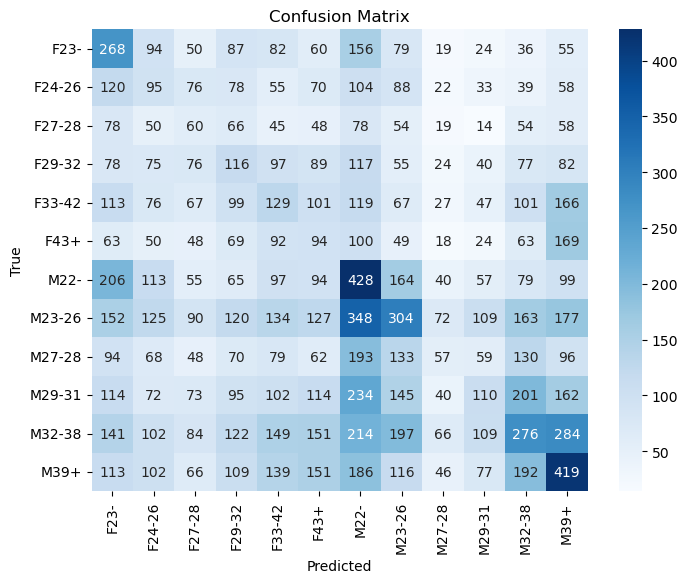

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 計算Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_test)

# 顯示Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()